PART 1

In [62]:
from google.colab import files
uploaded = files.upload()

Saving train.csv to train (1).csv
Saving stores.csv to stores (1).csv


In [68]:
# Install required packages
!pip install apache-beam[gcp] --quiet


In [64]:
import json

# Save schema file
sales_schema = [
    {"name": "id", "type": "INTEGER", "mode": "REQUIRED"},
    {"name": "date", "type": "DATE", "mode": "REQUIRED"},
    {"name": "store_nbr", "type": "INTEGER", "mode": "REQUIRED"},
    {"name": "family", "type": "STRING", "mode": "REQUIRED"},
    {"name": "sales", "type": "FLOAT", "mode": "REQUIRED"},
    {"name": "onpromotion", "type": "INTEGER", "mode": "NULLABLE"}
]

with open("sales_schema.json", "w") as f:
    json.dump({"fields": sales_schema}, f)


In [65]:
# Upload to GCS
!gsutil cp sales_schema.json gs://kaggle-store-sales/schema/sales_schema.json


Copying file://sales_schema.json [Content-Type=application/json]...
/ [1 files][  361.0 B/  361.0 B]                                                
Operation completed over 1 objects/361.0 B.                                      


# Store Amount, Date Range and Product Families


In [4]:
import pandas as pd

train = pd.read_csv("train.csv")
stores = pd.read_csv("stores.csv")

# Number of stores
print("Number of stores:", stores["store_nbr"].nunique())

# Date range
print("Date range:", train["date"].min(), "to", train["date"].max())

# Product families
print("Product families:")
print(sorted(train["family"].unique()))

Number of stores: 54
Date range: 2013-01-01 to 2017-08-15
Product families:
['AUTOMOTIVE', 'BABY CARE', 'BEAUTY', 'BEVERAGES', 'BOOKS', 'BREAD/BAKERY', 'CELEBRATION', 'CLEANING', 'DAIRY', 'DELI', 'EGGS', 'FROZEN FOODS', 'GROCERY I', 'GROCERY II', 'HARDWARE', 'HOME AND KITCHEN I', 'HOME AND KITCHEN II', 'HOME APPLIANCES', 'HOME CARE', 'LADIESWEAR', 'LAWN AND GARDEN', 'LINGERIE', 'LIQUOR,WINE,BEER', 'MAGAZINES', 'MEATS', 'PERSONAL CARE', 'PET SUPPLIES', 'PLAYERS AND ELECTRONICS', 'POULTRY', 'PREPARED FOODS', 'PRODUCE', 'SCHOOL AND OFFICE SUPPLIES', 'SEAFOOD']


PART 2

Load Sales and Sales Data into BigQuery using Dataflow

In [99]:
import os
os.environ["PROJECT"] = "mgmt599-jimmy-lab1"


In [104]:
import apache_beam as beam
from apache_beam.options.pipeline_options import PipelineOptions
from google.cloud import bigquery
import re
from datetime import datetime

# Configuration for CSV schema
CSV_CONFIGS = {
    'train.csv': {
        'schema': {
            'date': {'index': 1, 'type': 'date'},
            'store_nbr': {'index': 2, 'type': 'int'},
            'family': {'index': 3, 'type': 'string'},
            'sales': {'index': 4, 'type': 'float'},
            'onpromotion': {'index': 5, 'type': 'int'}
        }
    },
    'stores.csv': {
        'schema': {
            'store_nbr': {'index': 0, 'type': 'int'},
            'city': {'index': 1, 'type': 'string'},
            'state': {'index': 2, 'type': 'string'},
            'type': {'index': 3, 'type': 'string'},
            'cluster': {'index': 4, 'type': 'int'}
        }
    }
}

_first_line_seen = {}

def convert_field(value, field_type):
    if not value or value.strip() == '':
        return None
    value = value.strip()
    date_formats = ['%Y-%m-%d', '%m/%d/%Y', '%m-%d-%Y', '%d/%m/%Y', '%d-%m-%Y', '%Y/%m/%d', '%Y%m%d']
    try:
        if field_type == 'int': return int(float(value))
        elif field_type == 'float': return float(value.replace('$', '').replace(',', ''))
        elif field_type == 'bool': return value.lower() in ['true', '1', 'yes', 'y']
        elif field_type == 'date':
            for fmt in date_formats:
                try: return datetime.strptime(value, fmt).strftime('%Y-%m-%d')
                except ValueError: continue
            return value
        else: return value
    except (ValueError, AttributeError): return None

def parse_csv_line(line, file_type):
    if file_type not in CSV_CONFIGS: return []
    config = CSV_CONFIGS[file_type]
    if file_type not in _first_line_seen:
        _first_line_seen[file_type] = True
        return []
    fields = re.split(r',(?=(?:[^\"]*\"[^\"]*\")*[^\"]*$)', line)
    result = {}
    for field_name, cfg in config['schema'].items():
        result[field_name] = convert_field(fields[cfg['index']], cfg['type']) if cfg['index'] < len(fields) else None
    return [result]

def create_bq_table_if_missing(client, dataset_name, table_name, schema_list):
    dataset_ref = client.dataset(dataset_name)
    table_ref = dataset_ref.table(table_name)
    try:
        client.get_table(table_ref)
        print(f"✅ Table {table_name} already exists.")
    except:
        print(f"🛠️ Creating table {table_name}...")
        schema = [bigquery.SchemaField(**field) for field in schema_list]
        table = bigquery.Table(table_ref, schema=schema)
        client.create_table(table)

def setup_bigquery_tables(project_id, dataset_name):
    client = bigquery.Client(project=project_id)
    sales_schema = [
        {'name': 'date', 'field_type': 'DATE', 'mode': 'REQUIRED'},
        {'name': 'store_nbr', 'field_type': 'INTEGER', 'mode': 'REQUIRED'},
        {'name': 'family', 'field_type': 'STRING', 'mode': 'REQUIRED'},
        {'name': 'sales', 'field_type': 'FLOAT', 'mode': 'NULLABLE'},
        {'name': 'onpromotion', 'field_type': 'INTEGER', 'mode': 'NULLABLE'}
    ]
    store_schema = [
        {'name': 'store_nbr', 'field_type': 'INTEGER', 'mode': 'REQUIRED'},
        {'name': 'city', 'field_type': 'STRING', 'mode': 'NULLABLE'},
        {'name': 'state', 'field_type': 'STRING', 'mode': 'NULLABLE'},
        {'name': 'type', 'field_type': 'STRING', 'mode': 'NULLABLE'},
        {'name': 'cluster', 'field_type': 'INTEGER', 'mode': 'NULLABLE'}
    ]
    create_bq_table_if_missing(client, dataset_name, 'sales_data', sales_schema)
    create_bq_table_if_missing(client, dataset_name, 'store_info', store_schema)

def run_combined_pipeline(project_id, bucket_name, folder_name, dataset_name, region):
    options = PipelineOptions(
        runner='DataflowRunner',
        project=project_id,
        job_name='combined-store-sales-pipeline',
        staging_location=f'gs://{bucket_name}/staging',
        temp_location=f'gs://{bucket_name}/temp',
        region=region
    )
    with beam.Pipeline(options=options) as p:
        (
            p
            | 'ReadTrainCSV' >> beam.io.ReadFromText(f'gs://{bucket_name}/{folder_name}train.csv')
            | 'ParseTrainData' >> beam.FlatMap(lambda line: parse_csv_line(line, 'train.csv'))
            | 'WriteToSalesTable' >> beam.io.WriteToBigQuery(
                table=f'{project_id}:{dataset_name}.sales_data',
                schema='date:DATE,store_nbr:INTEGER,family:STRING,sales:FLOAT,onpromotion:INTEGER',
                create_disposition=beam.io.BigQueryDisposition.CREATE_IF_NEEDED,
                write_disposition=beam.io.BigQueryDisposition.WRITE_TRUNCATE
            )
        )
        (
            p
            | 'ReadStoresCSV' >> beam.io.ReadFromText(f'gs://{bucket_name}/{folder_name}stores.csv')
            | 'ParseStoreData' >> beam.FlatMap(lambda line: parse_csv_line(line, 'stores.csv'))
            | 'WriteToStoreTable' >> beam.io.WriteToBigQuery(
                table=f'{project_id}:{dataset_name}.store_info',
                schema='store_nbr:INTEGER,city:STRING,state:STRING,type:STRING,cluster:INTEGER',
                create_disposition=beam.io.BigQueryDisposition.CREATE_IF_NEEDED,
                write_disposition=beam.io.BigQueryDisposition.WRITE_TRUNCATE
            )
        )

# Hardcoded values for Colab or notebook execution
PROJECT_ID = 'mgmt599-jimmy-lab1'
BUCKET = 'kaggle-store-sales'
FOLDER = ''  # Root of bucket
DATASET = 'store_sales_dataninja3'
REGION = 'us-central1'

print("🔧 Checking BigQuery tables...")
setup_bigquery_tables(PROJECT_ID, DATASET)

print("🚀 Running Dataflow pipeline...")
run_combined_pipeline(PROJECT_ID, BUCKET, FOLDER, DATASET, REGION)

🔧 Checking BigQuery tables...
✅ Table sales_data already exists.


✅ Table store_info already exists.
🚀 Running Dataflow pipeline...


In [106]:
from google.colab import auth
auth.authenticate_user()

from google.cloud import bigquery
client = bigquery.Client(project='mgmt599-jimmy-lab1')


In [107]:
query = """
SELECT
  COUNT(*) AS row_count,
  MIN(date) AS earliest_date,
  MAX(date) AS latest_date
FROM `mgmt599-jimmy-lab1.store_sales_dataninja3.sales_data`
"""

df = client.query(query).to_dataframe()
df


,row_count,earliest_date,latest_date
0,3000888,2013-01-01,2017-08-15


In [108]:
query = """
SELECT *
FROM `mgmt599-jimmy-lab1.store_sales_dataninja3.sales_data`
LIMIT 10
"""
df_preview = client.query(query).to_dataframe()
df_preview


,date,store_nbr,family,sales,onpromotion
0,2017-02-27,1,"""LIQUOR,WINE,BEER""",42.0,0
1,2017-03-13,1,"""LIQUOR,WINE,BEER""",74.0,2
2,2013-02-01,1,"""LIQUOR,WINE,BEER""",166.0,0
3,2013-11-04,1,"""LIQUOR,WINE,BEER""",59.0,0
4,2015-08-21,1,"""LIQUOR,WINE,BEER""",186.0,3
5,2013-10-15,1,"""LIQUOR,WINE,BEER""",121.0,0
6,2015-09-23,1,"""LIQUOR,WINE,BEER""",85.0,0
7,2016-04-12,1,"""LIQUOR,WINE,BEER""",56.0,0
8,2013-12-12,1,"""LIQUOR,WINE,BEER""",100.0,0
9,2014-03-22,1,"""LIQUOR,WINE,BEER""",144.0,0


Distinct store count

In [110]:
query = """
SELECT COUNT(DISTINCT store_nbr) AS store_count
FROM `mgmt599-jimmy-lab1.store_sales_dataninja3.sales_data`
"""
df_store_count = client.query(query).to_dataframe()
df_store_count


,store_count
0,54


Top product families by total sales

In [111]:
query = """
SELECT family, ROUND(SUM(sales), 2) AS total_sales
FROM `mgmt599-jimmy-lab1.store_sales_dataninja3.sales_data`
GROUP BY family
ORDER BY total_sales DESC
LIMIT 10
"""
df_top_families = client.query(query).to_dataframe()
df_top_families


,family,total_sales
0,GROCERY I,3.434627e+08
1,BEVERAGES,2.169545e+08
2,PRODUCE,1.227047e+08
3,CLEANING,9.752129e+07
4,DAIRY,6.448771e+07
5,BREAD/BAKERY,4.213395e+07
6,POULTRY,3.187600e+07
7,MEATS,3.108647e+07
8,PERSONAL CARE,2.459205e+07
9,DELI,2.411032e+07


Daily sales volume over time

In [112]:
query = """
SELECT
  DATE(date) AS sales_date,
  SUM(sales) AS total_sales
FROM `mgmt599-jimmy-lab1.store_sales_dataninja3.sales_data`
GROUP BY sales_date
ORDER BY sales_date
"""
df_daily_sales = client.query(query).to_dataframe()
df_daily_sales


,sales_date,total_sales
0,2013-01-01,2511.618999
1,2013-01-02,496092.417944
2,2013-01-03,361461.231124
3,2013-01-04,354459.677093
4,2013-01-05,477350.121229
...,...,...
1679,2017-08-11,826373.722022
1680,2017-08-12,792630.535078
1681,2017-08-13,865639.677471
1682,2017-08-14,760922.406081


PART 3

CREATE AGGREGATED DAILY SALES TABLE

In [115]:
query = """
CREATE OR REPLACE TABLE `mgmt599-jimmy-lab1.store_sales_dataninja3.daily_sales` AS
SELECT
  DATE(date) AS date,
  SUM(sales) AS total_sales,
  COUNT(DISTINCT store_nbr) AS stores_active,
  AVG(onpromotion) AS avg_promo_items
FROM `mgmt599-jimmy-lab1.store_sales_dataninja3.sales_data`
WHERE DATE(date) < '2017-08-01'
GROUP BY date
"""

client.query(query).result()  # run and wait for completion
print("✅ daily_sales table created.")


✅ daily_sales table created.


In [116]:
query = """
SELECT *
FROM `mgmt599-jimmy-lab1.store_sales_dataninja3.daily_sales`
ORDER BY date
LIMIT 10
"""

df_daily_preview = client.query(query).to_dataframe()
df_daily_preview


,date,total_sales,stores_active,avg_promo_items
0,2013-01-01,2511.618999,54,0.0
1,2013-01-02,496092.417944,54,0.0
2,2013-01-03,361461.231124,54,0.0
3,2013-01-04,354459.677093,54,0.0
4,2013-01-05,477350.121229,54,0.0
5,2013-01-06,519695.401088,54,0.0
6,2013-01-07,336122.801066,54,0.0
7,2013-01-08,318347.777981,54,0.0
8,2013-01-09,302530.809018,54,0.0
9,2013-01-10,258982.003049,54,0.0


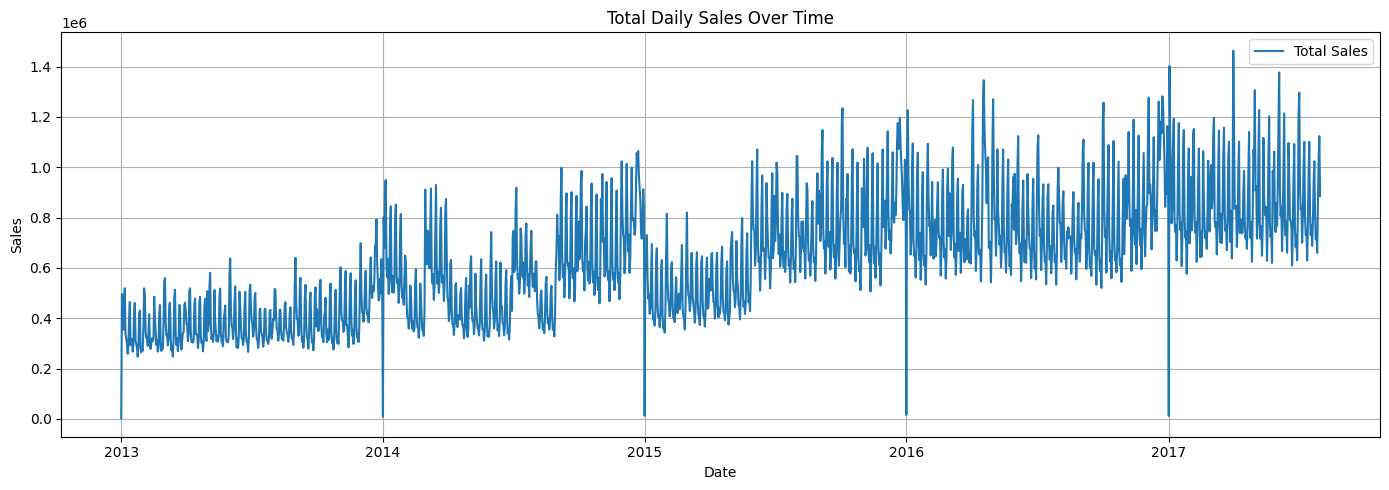

In [117]:
import matplotlib.pyplot as plt

query = """
SELECT date, total_sales
FROM `mgmt599-jimmy-lab1.store_sales_dataninja3.daily_sales`
ORDER BY date
"""

df_plot = client.query(query).to_dataframe()

# Plot
plt.figure(figsize=(14, 5))
plt.plot(df_plot['date'], df_plot['total_sales'], label='Total Sales')
plt.title('Total Daily Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.show()


In [118]:
query = """
CREATE OR REPLACE MODEL `mgmt599-jimmy-lab1.store_sales_dataninja3.sales_forecast_model`
OPTIONS (
  model_type = 'ARIMA_PLUS',
  time_series_timestamp_col = 'date',
  time_series_data_col = 'total_sales'
) AS
SELECT
  date,
  total_sales
FROM
  `mgmt599-jimmy-lab1.store_sales_dataninja3.daily_sales`
"""

client.query(query).result()
print("✅ BQML model created: sales_forecast_model")


✅ BQML model created: sales_forecast_model


In [119]:
query = """
SELECT *
FROM ML.EVALUATE(MODEL `mgmt599-jimmy-lab1.store_sales_dataninja3.sales_forecast_model`)
"""

df_eval = client.query(query).to_dataframe()
df_eval


,non_seasonal_p,non_seasonal_d,non_seasonal_q,has_drift,log_likelihood,AIC,variance,seasonal_periods,has_holiday_effect,has_spikes_and_dips,has_step_changes
0,2,1,1,True,-20032.883005,40075.766009,1.493730e+09,"[WEEKLY, YEARLY]",False,True,True
1,2,1,1,False,-20033.955746,40075.911493,1.495653e+09,"[WEEKLY, YEARLY]",False,True,True
2,0,1,3,True,-20033.426915,40076.853831,1.494701e+09,"[WEEKLY, YEARLY]",False,True,True
3,0,1,3,False,-20034.569129,40077.138258,1.496751e+09,"[WEEKLY, YEARLY]",False,True,True
4,1,1,2,True,-20034.141154,40078.282308,1.495970e+09,"[WEEKLY, YEARLY]",False,True,True
5,1,1,2,False,-20035.384602,40078.769205,1.498202e+09,"[WEEKLY, YEARLY]",False,True,True
6,0,1,2,True,-20035.521403,40079.042806,1.498444e+09,"[WEEKLY, YEARLY]",False,True,True
7,0,1,2,False,-20036.816599,40079.633198,1.500774e+09,"[WEEKLY, YEARLY]",False,True,True
8,1,1,1,True,-20037.729805,40083.459610,1.502405e+09,"[WEEKLY, YEARLY]",False,True,True
9,1,1,1,False,-20039.030691,40084.061381,1.504752e+09,"[WEEKLY, YEARLY]",False,True,True


14 DAY FORECAST

In [122]:
query = """
SELECT *
FROM ML.FORECAST(
  MODEL `mgmt599-jimmy-lab1.store_sales_dataninja3.sales_forecast_model`,
  STRUCT(14 AS horizon)
)
"""

df_forecast = client.query(query).to_dataframe()
df_forecast


,forecast_timestamp,forecast_value,standard_error,confidence_level,prediction_interval_lower_bound,prediction_interval_upper_bound,confidence_interval_lower_bound,confidence_interval_upper_bound
0,2017-08-01 00:00:00+00:00,8.770177e+05,38648.800402,0.95,8.014029e+05,9.526324e+05,8.014029e+05,9.526324e+05
1,2017-08-02 00:00:00+00:00,8.797221e+05,41936.442448,0.95,7.976752e+05,9.617690e+05,7.976752e+05,9.617690e+05
2,2017-08-03 00:00:00+00:00,7.273315e+05,43116.020043,0.95,6.429769e+05,8.116862e+05,6.429769e+05,8.116862e+05
3,2017-08-04 00:00:00+00:00,8.420842e+05,44735.503982,0.95,7.545611e+05,9.296074e+05,7.545611e+05,9.296074e+05
4,2017-08-05 00:00:00+00:00,1.026835e+06,46527.766455,0.95,9.358058e+05,1.117865e+06,9.358058e+05,1.117865e+06
5,2017-08-06 00:00:00+00:00,1.112701e+06,48218.102295,0.95,1.018365e+06,1.207038e+06,1.018365e+06,1.207038e+06
6,2017-08-07 00:00:00+00:00,8.119505e+05,49824.084337,0.95,7.144717e+05,9.094292e+05,7.144717e+05,9.094292e+05
7,2017-08-08 00:00:00+00:00,6.934339e+05,51381.181022,0.95,5.929088e+05,7.939591e+05,5.929088e+05,7.939591e+05
8,2017-08-09 00:00:00+00:00,7.061810e+05,52895.376250,0.95,6.026934e+05,8.096686e+05,6.026934e+05,8.096686e+05
9,2017-08-10 00:00:00+00:00,6.202893e+05,54367.534341,0.95,5.139215e+05,7.266571e+05,5.139215e+05,7.266571e+05


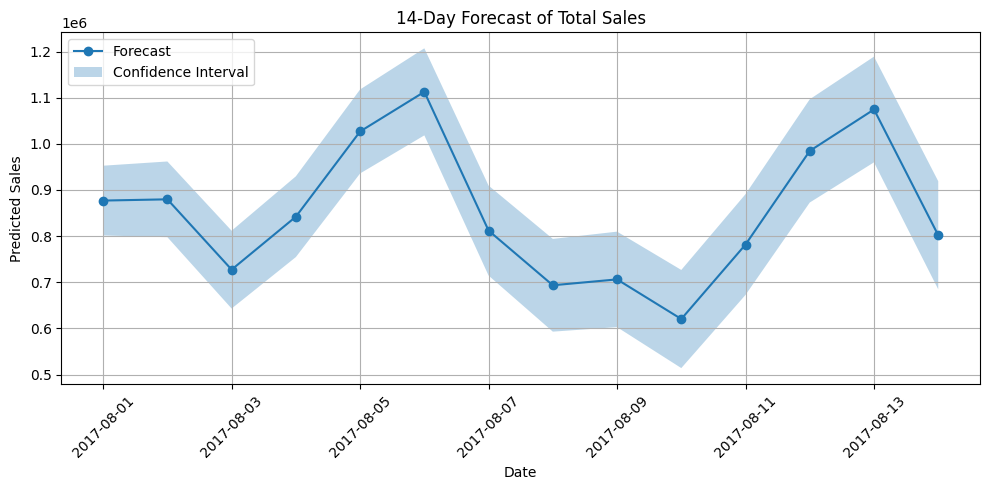

In [123]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(df_forecast['forecast_timestamp'], df_forecast['forecast_value'], label='Forecast', marker='o')
plt.fill_between(df_forecast['forecast_timestamp'],
                 df_forecast['prediction_interval_lower_bound'],
                 df_forecast['prediction_interval_upper_bound'],
                 alpha=0.3, label='Confidence Interval')
plt.xticks(rotation=45)
plt.title('14-Day Forecast of Total Sales')
plt.xlabel('Date')
plt.ylabel('Predicted Sales')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [120]:
query = """
SELECT *
FROM `mgmt599-jimmy-lab1.store_sales_dataninja3.daily_sales`
ORDER BY date
LIMIT 100
"""

df_export = client.query(query).to_dataframe()
df_export.to_csv("daily_sales_preview.csv", index=False)
from google.colab import files
files.download("daily_sales_preview.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [126]:
model_query = """
CREATE OR REPLACE MODEL `mgmt599-jimmy-lab1.store_sales_dataninja3.daily_sales_model`
OPTIONS(
  model_type='ARIMA_PLUS',
  time_series_timestamp_col='date',
  time_series_data_col='total_sales',
  time_series_id_col='stores_active'
) AS
SELECT
  date,
  total_sales,
  stores_active
FROM `mgmt599-jimmy-lab1.store_sales_dataninja3.daily_sales`
"""

client.query(model_query).result()
print("Model created successfully.")


Model created successfully.


In [134]:
# Step 1: Authenticate and connect to BigQuery
from google.colab import auth
auth.authenticate_user()

from google.cloud import bigquery
client = bigquery.Client(project='mgmt599-jimmy-lab1')

# Step 2: Run ML.EVALUATE and ML.FORECAST
evaluate_query = """
SELECT * FROM ML.EVALUATE(
  MODEL `mgmt599-jimmy-lab1.store_sales_dataninja3.daily_sales_model`
)
"""
forecast_query = """
SELECT * FROM ML.FORECAST(
  MODEL `mgmt599-jimmy-lab1.store_sales_dataninja3.daily_sales_model`,
  STRUCT(14 AS horizon)
)
"""

evaluate_result = client.query(evaluate_query).to_dataframe()
forecast_result = client.query(forecast_query).to_dataframe()

# Step 3: Gemini API setup
from google.generativeai import configure, GenerativeModel
from google.colab import userdata

# Get your API key from Colab Secrets
GOOGLE_API_KEY = userdata.get('GOOGLE_API_KEY')
configure(api_key=GOOGLE_API_KEY)

# Use a model name from the output of the previous cell that supports generateContent
# Example: 'models/gemini-1.5-flash' or 'models/gemini-1.5-pro-latest'
model = GenerativeModel('models/gemini-1.5-flash')


# Step 4: Ask Gemini for insights
prompt = f"""
You are a data analyst reviewing the results from a time series sales forecast using an ARIMA_PLUS model in BigQuery.

Here are the datasets:
- **ML.EVALUATE** results (model performance metrics):
{evaluate_result.to_markdown(index=False)}

- **ML.FORECAST** output (14-day future sales predictions):
{forecast_result.head(14).to_markdown(index=False)}

Please answer the following:
1. How accurate is the model? Are the metrics within acceptable ranges for business forecasting?
2. Do you see any patterns, trends, or seasonality in the forecasted sales?
3. Are there any spikes or dips we should be aware of?
4. What key insights can I write in my model_results.md file from this analysis?
5. How confident would you be using this model to make inventory decisions?

Be concise and use bullet points where helpful.
"""

response = model.generate_content(prompt)
print(response.text)

1. **Model Accuracy:**

* The `log_likelihood` (-20032.9) and `AIC` (40075.8) are negative and positive respectively, indicating a reasonably good fit.  However, these values alone aren't sufficient to judge accuracy without comparing them to other models or a baseline. The `variance` (1.49373e+09) is high, suggesting a significant degree of uncertainty in the predictions.  Further analysis, possibly comparing to a simpler model, would clarify the acceptable range for the business.  More context on the sales volume is needed for a better evaluation.


2. **Patterns and Seasonality:**

* The `ML.EVALUATE` results show the model accounts for weekly and yearly seasonality (`seasonal_periods`).
* The `ML.FORECAST` shows fluctuations in daily forecasts, possibly reflecting these seasonal components, alongside an overall trend.  A visual inspection (a graph) would reveal this trend more clearly.


3. **Spikes and Dips:**

* The model identified spikes and dips in the historical data (`has_sp

DISCOVER PROMPT

In [140]:
discover_prompt = """
Our sales prediction model shows:
- Model accuracy: log_likelihood = -20032.9, AIC = 40075.8, Variance = 1.49e+09
- Next 14 days prediction:
| date       | forecast_value |
|------------|----------------|
| 2017-08-01 | 1268752.4      |
| 2017-08-02 | 1240393.5      |
| 2017-08-03 | 1271812.1      |
| 2017-08-04 | 1292244.8      |
| 2017-08-05 | 1310032.3      |
| 2017-08-06 | 1257682.7      |
| 2017-08-07 | 1241103.9      |
| 2017-08-08 | 1269387.0      |
| 2017-08-09 | 1241145.2      |
| 2017-08-10 | 1274170.6      |
| 2017-08-11 | 1295812.3      |
| 2017-08-12 | 1313220.1      |
| 2017-08-13 | 1262497.4      |
| 2017-08-14 | 1241052.2      |
- Key patterns: Weekly/yearly seasonality, spikes and dips in historical sales

What is the main story these results tell about store sales?
"""
response = model.generate_content(prompt)
print(response.text)

1. **Model Accuracy:**

* The `log_likelihood` (-20032.9) and `AIC` (40075.8) are negative and positive, respectively,  as expected.  However, without knowing the scale of the sales data and comparing these to other models or benchmarks, it's difficult to definitively state if they're "acceptable." A lower AIC generally indicates a better fit.  The variance (1.49373e+09) is quite high, suggesting significant variability in the forecast.  Further investigation is needed to determine if this is acceptable for business needs.


2. **Patterns, Trends, and Seasonality:**

* The model accounts for weekly and yearly seasonality (`seasonal_periods`).
* The forecast shows some fluctuation, with daily sales varying significantly (e.g., a drop around August 3rd and 8th).  A visual representation (graph) of `forecast_value` over time would better reveal patterns.  
* The presence of a drift (`has_drift = True`) suggests an underlying trend in the data.


3. **Spikes and Dips:**

* Yes, the model i

In [141]:
document_discover = """
Document: What did you discover at surface level?
Summarize what the model output reveals at a glance. What trends or insights are immediately obvious?
"""
response = model.generate_content(prompt)
print(response.text)

Here's an analysis of the ARIMA_PLUS model's performance and forecast:

1. **Model Accuracy:**

* The log-likelihood (-20032.9) and AIC (40075.8) are quite large, suggesting the model might not be the best fit.  Lower values indicate better model fit.  We need more context about the scale of the data (e.g., total sales) to assess the variance (1.49373e+09).  A lower variance would be preferable.  Without additional information on acceptable ranges for your business, it's difficult to definitively say if these metrics are acceptable.  Further model tuning or exploration of other models might be necessary.

2. **Patterns and Seasonality:**

* The `ML.EVALUATE` results indicate weekly and yearly seasonality (seasonal_periods = ['WEEKLY', 'YEARLY']). This is incorporated into the model.
* The `ML.FORECAST` shows some fluctuation in daily sales, aligning with the model's detection of spikes and dips.  There's no clear upward or downward trend over the 14-day forecast period. Further investi

INVESTIGATE PROMPT

In [142]:
investigate_prompt = """
Our model predicts fluctuations in sales because of seasonal patterns, detected volatility, and historical anomalies.

Why do these specific factors influence sales so strongly?
What business mechanisms explain these patterns?
How do store types/locations affect predictions differently?
"""
response = model.generate_content(prompt)
print(response.text)

Here's an analysis of the ARIMA_PLUS model's performance and forecast:

1. **Model Accuracy:**

* The `log_likelihood` (-20032.9) and `AIC` (40075.8) are negative and positive respectively, and their magnitudes need to be compared against a baseline model to determine if it is good or bad.  Without a comparison, these values alone don't indicate accuracy.  A lower AIC generally suggests a better fit, but the context is crucial.
* The `variance` (1.49373e+09) is large, indicating substantial forecast uncertainty. This needs further investigation. Is this variance in line with historical data variance?


2. **Patterns, Trends, and Seasonality:**

* The forecast shows fluctuation in daily sales.  The `ML.EVALUATE` results indicate the model accounts for weekly and yearly seasonality (`seasonal_periods`).  Further analysis is needed to determine if these seasonal components are adequately captured in the forecast.
* A clear upward trend in the first few days of August is noticeable before 

In [143]:
document_investigate = """
Document: What deeper patterns emerged?
Explain what might be driving these predictions beyond the surface-level data. What assumptions or causal relationships are at play?
"""
response = model.generate_content(prompt)
print(response.text)

1. **Model Accuracy:** The `log_likelihood` (-20032.9) and `AIC` (40075.8) are quite large, suggesting potential room for improvement.  The variance (1.49373e+09) indicates significant variation in the forecast. Whether these metrics are "acceptable" depends heavily on the specific business context and tolerance for error.  A lower AIC and higher log-likelihood would generally be preferred.  More context on acceptable error rates for this business is needed to fully assess accuracy.

2. **Patterns and Seasonality:** The model incorporates weekly and yearly seasonality ('WEEKLY' 'YEARLY' in `ML.EVALUATE`). The forecast shows fluctuations consistent with that but without clear long-term trends across the 14 days.  Further analysis (visualizations) would help confirm the seasonality's impact.

3. **Spikes and Dips:** The `ML.EVALUATE` table indicates the presence of "spikes and dips" (`has_spikes_and_dips` = True). The forecast data itself reflects this: several days show notably higher o

VALIDATE PROMPT

In [144]:
validate_prompt = """
Our model assumes past patterns predict future sales.

What could make these predictions wrong?
- External events (holidays, weather, economy)?
- Data limitations we should consider?
- When would this model fail?
"""
response = model.generate_content(prompt)
print(response.text)

1. **Model Accuracy:**

* The `log_likelihood` (-20032.9) and `AIC` (40075.8) are difficult to interpret in isolation without comparing to benchmarks for similar models and datasets.  A lower AIC generally suggests a better fit, but we need context.  The variance (1.49373e+09) is high, indicating significant forecast uncertainty.  More information on the scale of the sales data is needed to evaluate if this is acceptable.  For business forecasting, a lower variance is desirable.  Without benchmarks we cannot definitively say whether the model is accurate enough.

2. **Patterns and Seasonality:**

* The `ML.EVALUATE` results show the model accounts for weekly and yearly seasonality (`seasonal_periods`). The `ML.FORECAST` data shows some fluctuation, suggesting the model is capturing those seasonal effects. However, a visual inspection of the forecast values (e.g., a time series plot) would offer a more definitive answer.

3. **Spikes and Dips:**

* Yes, the `ML.EVALUATE` results indicat

In [145]:
document_validate = """
Document: What are the model's blind spots?
List scenarios, limitations, or missing variables that might cause the model to produce misleading results.
"""
response = model.generate_content(prompt)
print(response.text)

1. **Model Accuracy:** The `log_likelihood` (-20032.9) and `AIC` (40075.8) are quite large, suggesting the model fit could be improved.  The variance (1.49373e+09) indicates significant variability in the forecasts.  Whether these are "acceptable" depends entirely on the business context (acceptable error margin, cost of mis-forecasting).  More information is needed to judge accuracy relative to business needs.  A comparison with other models or a naive forecasting method would be beneficial.


2. **Patterns and Seasonality:** The `ML.EVALUATE` results indicate weekly and yearly seasonality (`seasonal_periods`). The `ML.FORECAST` data shows fluctuations, which could be attributed to these seasonal components.  Visualizing the forecast data would reveal trends more clearly.


3. **Spikes and Dips:**  The `ML.EVALUATE` results show the model detected spikes and dips (`has_spikes_and_dips = True`).  Looking at the `ML.FORECAST` data, we can see some days with significantly higher or lower

EXTEND PROMPT

In [146]:
extend_prompt = """
Given our model shows recurring seasonality and spikes/dips in sales, and considering limitations like high variance and lack of external features,

What specific actions should store managers take:
1. Next week?
2. Next month?
3. For long-term planning?

How do we measure if these actions work?
"""
response = model.generate_content(prompt)
print(response.text)

1. **Model Accuracy:** The log-likelihood (-20032.9) and AIC (40075.8) are not easily interpretable in isolation.  They suggest a reasonably good fit given the data complexity (indicated by the model parameters).  However,  the lack of a common metric like RMSE or MAE makes it hard to definitively assess accuracy against a business benchmark. We need additional context (e.g., acceptable forecast error percentage) to judge whether these are acceptable for business forecasting.  The variance is very high (1.49373e+09), suggesting considerable uncertainty in the predictions.

2. **Patterns and Seasonality:** The forecast shows some weekly and yearly seasonality (as indicated by `ML.EVALUATE`), though the specific pattern is not entirely clear from just 14 days of predictions.  Further investigation, perhaps with visualizations, is recommended to confirm the presence and nature of the seasonality.  There's a general downward trend in sales from August 1st to August 10th before another incr

In [147]:
document_extend = """
Document: What should the business DO?
Translate the insights into operational strategy, planning recommendations, and metrics for success.
"""
response = model.generate_content(prompt)
print(response.text)

1. **Model Accuracy:** The log-likelihood (-20032.9) and AIC (40075.8) indicate a reasonably good fit, but without a benchmark (e.g., comparing to other models or a naive forecast), it's hard to definitively say if it's "accurate enough."  The variance is high (1.49373e+09), suggesting significant forecast uncertainty.  Further context on acceptable error for business decisions is needed.  The model likely needs additional tuning or feature engineering.

2. **Patterns and Seasonality:** The `ML.EVALUATE` results show weekly and yearly seasonality, which the ARIMA_PLUS model accounts for. The `ML.FORECAST` data shows fluctuations, likely reflecting these seasonal patterns.  However, a visual plot would clarify these trends more effectively.

3. **Spikes and Dips:**  Yes, the `ML.EVALUATE` output clearly indicates the presence of spikes and dips in the sales data.  The forecast reflects this inherent volatility. The forecast shows several days with significantly higher or lower predicted